<a href="https://colab.research.google.com/github/StillWork/ds-lab/blob/master/gg_49_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EC%9A%B0%EA%B8%B0%EC%B4%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST with RandomForest

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import numpy as np

(X_train, Y_class_train), (X_test, Y_class_test) = mnist.load_data()
X_train.shape, Y_class_train.shape

11490434/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,))

In [5]:
X_train.shape, Y_class_train.shape

((60000, 28, 28), (60000,))

In [6]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_train.reshape(X_train.shape[0], 28*28), Y_class_train)
rfc.score(X_test.reshape(X_test.shape[0], 28*28), Y_class_test)

0.9687

# MNIST with Tensorflow 2.0

### Version 1
- from internet
- Multi-class logistic regression (simple MLP without hidden layer)




In [7]:
import tensorflow as tf
import numpy as np

In [8]:
# loading and preparing mnist dataset

from tensorflow.keras.datasets import mnist
num_classes = 10        # 0 to 9 digits
num_features = 28 * 28

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.

In [9]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [10]:
learning_rate = 0.01
training_steps = 4000
batch_size = 32

# shuffling and batching the dataset

train_data=tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_data=train_data.repeat().shuffle(5000).batch(batch_size)

In [11]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

In [12]:
# initializing weights and biases

W = tf.Variable(tf.random.normal([num_features, num_classes]), name="weight") # (784,10)
b = tf.Variable(tf.random.normal([num_classes]), name="bias")                # (10,)
W.shape, b.shape

(TensorShape([784, 10]), TensorShape([10]))

In [14]:
# defining logistic regression and cost function

def logistic_regression(x):
    # print(x.shape)    # (batch_size,784)
    return tf.nn.softmax(tf.matmul(x, W) + b)

In [15]:
# for exercise
tf.nn.softmax([1.,1.,0.,0.])

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.36552927, 0.36552927, 0.13447072, 0.13447072], dtype=float32)>

In [16]:
def cross_entropy(y_pred, y_true):
    # print(y_pred.shape, y_true.shape)   # (batch_size, 10) (batch_size,)
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)  # to avoid log(0) error
    ce1 = tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))
    ce0 = tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))       # wrong
    ce2 = tf.reduce_mean(tf.losses.categorical_crossentropy(y_true, y_pred)) # function
    return ce1

In [17]:
# for exercise
tmp_a = tf.constant([[1.,2.],[3.,4.]])
tmp_b = tf.constant([[0.,2.],[4.,6.]])
tmp_a*tmp_b, tf.reduce_sum(tmp_a*tmp_b, axis=1)

(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 0.,  4.],
        [12., 24.]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 4., 36.], dtype=float32)>)

In [18]:
# defining optimizers and accuracy metrics
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64)) # axis=1
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

optimizer = tf.optimizers.Adam(learning_rate)

# optimization process and updating weights and biases
def run_optimization(x, y):

    with tf.GradientTape() as tape:
        y_pred = logistic_regression(x)
        loss = cross_entropy(y_pred, y)

    gradients = tape.gradient(loss, [W, b])
    optimizer.apply_gradients(zip(gradients, [W, b]))  # updates

In [19]:
# the training loop
# dataset.take(c): Creates a Dataset with at most c elements from this dataset.
# batch_size 만큼씩 c 번 뽑는다.

lossHistory = []
accuracyHistory = []
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):

    # print(batch_x.shape, batch_y.shape)   # (batch_size,784), (batch_size,)
    run_optimization(batch_x, batch_y)

    if step % 50 == 0:
        pred = logistic_regression(batch_x)
        loss = cross_entropy(pred, batch_y)
        lossHistory.append(loss)
        acc = accuracy(pred, batch_y)
        accuracyHistory.append(acc)
        # print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

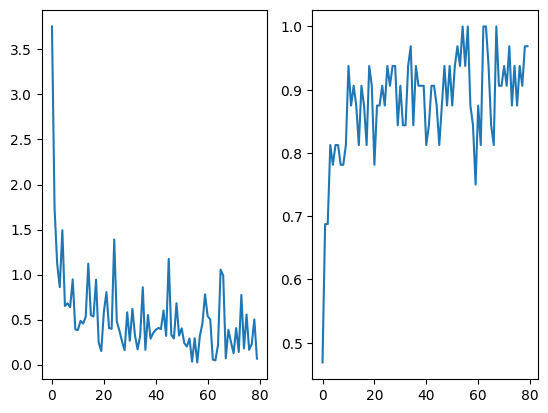

In [21]:
plt.subplot(1,2,1)
plt.plot(lossHistory)
plt.subplot(1,2,2)
plt.plot(accuracyHistory)

In [23]:
# testing model accuracy using the test data

pred = logistic_regression(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.897400


model prediction: 7
model prediction: 2
model prediction: 1
model prediction: 0
model prediction: 4


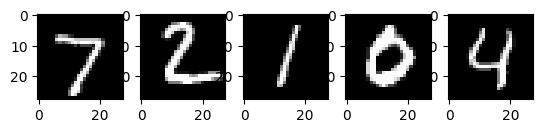

In [24]:
# visualizing the classification result

import matplotlib.pyplot as plt

n_images = 5
test_images = x_test[:n_images]
predictions = logistic_regression(test_images)

for i in range(n_images):
    plt.subplot(1,n_images, i+1)
    plt.imshow(np.reshape(test_images[i], [28,28]), cmap='gray')
    print('model prediction: %i' %np.argmax(predictions.numpy()[i]))
plt.show()

## Version 2
- put all together (for easy migration from the simpler regression code)

In [25]:
from tensorflow.keras.datasets import mnist

num_classes = 10        # 0 to 9 digits
num_features = 28 * 28
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.

In [26]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [36]:
input_size = 784
num_classes = 10
batch_size = 300
num_epochs = 5
learning_rate = 0.01

- **tf.data.Dataset** API : supports writing descriptive and efficient input pipelines.
  - create a source dataset from your input data.
  - Apply dataset transformations to preprocess the data.
  - Iterate over the dataset and process the elements.
- Iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.

In [33]:
train_data=tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_data=train_data.shuffle(5000).batch(batch_size)

In [34]:
W = tf.Variable(tf.random.normal([input_size, num_classes])) # (784,10)
b = tf.Variable(tf.random.normal([num_classes]))             # (10,)

In [35]:
def logistic_regression(x):
    # print(x.shape)    # (batch_size,784)
    return tf.nn.softmax(tf.matmul(x, W) + b)

def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64)) # axis=1
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [37]:
# Training
lossHistory = []
accuracyHistory = []

for e in range( num_epochs ):
    for step, (batch_x, batch_y) in enumerate(train_data, 1):
        with tf.GradientTape() as tape:
            y_pred = tf.nn.softmax(tf.matmul(batch_x, W) + b)
            y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
            batch_y_ohe = tf.one_hot(batch_y, depth = 10)
            loss = tf.reduce_mean(tf.losses.categorical_crossentropy( batch_y_ohe , y_pred ))
            # loss = tf.reduce_mean(-tf.reduce_sum(batch_y * tf.math.log(y_pred), axis=1))

        grads = tape.gradient(loss, [W, b])
        optimizer = tf.optimizers.Adam( learning_rate )
        # Adam 과 SGD 비교해 보면 좋음.
        optimizer.apply_gradients(zip(grads, [W,b]))

        corr_predict = tf.equal(tf.argmax(y_pred, 1), tf.cast(batch_y, tf.int64))
        acc = tf.reduce_mean(tf.cast(corr_predict, tf.float32))

        if step % 50 == 0:
            pred = logistic_regression(batch_x)
            loss = cross_entropy(pred, batch_y)
            lossHistory.append(loss)
            acc = accuracy(pred, batch_y)
            accuracyHistory.append(acc)
            print("epoch: %i, step: %i, loss: %f, acc: %f" % (e, step, loss, acc))

    # print("epoch: %i, loss: %f, accuracy: %f" % (e, loss, acc))

# Testing
test_y_pred = tf.nn.softmax(tf.matmul(x_test, W) + b)
test_pred = tf.equal(tf.argmax(test_y_pred, 1), tf.cast(y_test, tf.int64))
test_acc = tf.reduce_mean(tf.cast(test_pred, tf.float32))

print("Test accuracy: %f" % test_acc)

epoch: 0, step: 50, loss: 1.643083, acc: 0.690000
epoch: 0, step: 100, loss: 0.848124, acc: 0.806667
epoch: 0, step: 150, loss: 0.651173, acc: 0.863333


KeyboardInterrupt: ignored

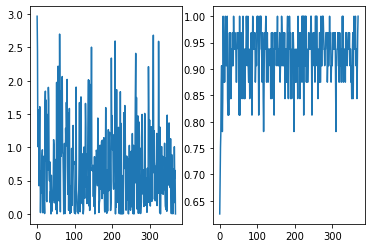

In [ ]:
plt.subplot(1,2,1)
plt.plot(lossHistory)
plt.subplot(1,2,2)
plt.plot(accuracyHistory)

# Version 3 (function define)

epoch: 0, step: 50, loss: 2.097796, acc: 0.640000
epoch: 0, step: 100, loss: 1.231940, acc: 0.796667
epoch: 0, step: 150, loss: 0.983322, acc: 0.806667
epoch: 0, step: 200, loss: 0.938953, acc: 0.843333
epoch: 1, step: 50, loss: 0.576271, acc: 0.880000
epoch: 1, step: 100, loss: 0.851900, acc: 0.826667
epoch: 1, step: 150, loss: 0.709069, acc: 0.863333
epoch: 1, step: 200, loss: 0.639769, acc: 0.893333
epoch: 2, step: 50, loss: 0.450365, acc: 0.910000
epoch: 2, step: 100, loss: 0.472682, acc: 0.883333
epoch: 2, step: 150, loss: 0.338620, acc: 0.910000
epoch: 2, step: 200, loss: 0.389239, acc: 0.906667
epoch: 3, step: 50, loss: 0.317879, acc: 0.906667
epoch: 3, step: 100, loss: 0.321668, acc: 0.910000
epoch: 3, step: 150, loss: 0.511103, acc: 0.900000
epoch: 3, step: 200, loss: 0.258747, acc: 0.923333
epoch: 4, step: 50, loss: 0.357516, acc: 0.896667
epoch: 4, step: 100, loss: 0.330100, acc: 0.916667
epoch: 4, step: 150, loss: 0.441737, acc: 0.890000
epoch: 4, step: 200, loss: 0.333183,

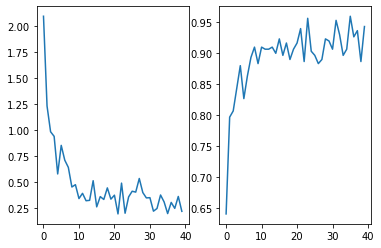

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
num_classes = 10        # 0 to 9 digits
num_features = 28 * 28
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.

input_size = 784
num_classes = 10
batch_size = 300
num_epochs = 10
learning_rate = 0.01

train_data=tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_data=train_data.shuffle(5000).batch(batch_size)

W = tf.Variable(tf.random.normal([input_size, num_classes])) # (784,10)
b = tf.Variable(tf.random.normal([num_classes]))             # (10,)

def model(X):
    return tf.nn.softmax(tf.matmul(X, W) + b)

def loss_fn(y_pred, y_true):
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    y_true_ohe = tf.one_hot(batch_y, depth = 10)
    return tf.reduce_mean(tf.losses.categorical_crossentropy(y_true_ohe, y_pred))

optimizer = tf.optimizers.Adam( learning_rate )

def train_step (x, y):

    with tf.GradientTape() as tape:
        y_pred = model(x)
        loss = loss_fn (y_pred, y)
    grads = tape.gradient(loss, [W, b])
    optimizer.apply_gradients(zip(grads, [W,b]))

def accuracy(y_pred, y_true):
    corr_predict = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(corr_predict, tf.float32))

# Training
lossHistory = []
accuracyHistory = []

for e in range( num_epochs ):
    for step, (batch_x, batch_y) in enumerate(train_data, 1):
        with tf.GradientTape() as tape:
            train_step(batch_x, batch_y)

        if step % 50 == 0:
            pred = model(batch_x)
            loss = loss_fn (pred, batch_y)
            acc = accuracy(pred, batch_y)
            print("epoch: %i, step: %i, loss: %f, acc: %f" % (e, step, loss, acc))
            lossHistory.append(loss)
            accuracyHistory.append(acc)

# Testing
test_y_pred = model(x_test)
test_acc = accuracy(test_y_pred, y_test)
print("Test accuracy: %f" % test_acc)

plt.subplot(1,2,1)
plt.plot(lossHistory)
plt.subplot(1,2,2)
plt.plot(accuracyHistory)
plt.show()

# Exercise

- dataset
- as_numpy_iterator(): returns an iterator which converts all elements of the dataset to numpy.
- Use this function to inspect the content of your dataset.
- To see element shapes and types, print dataset elements directly instead of using as_numpy_iterator.

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
for element in dataset:
    print(element)

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)


In [ ]:
print(list(dataset.as_numpy_iterator()))

[1, 2, 3]


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
dataset = dataset.map(lambda x: x*2)
list(dataset.as_numpy_iterator())

[2, 4, 6]

In [ ]:
dataset = tf.data.Dataset.range(8)
[i.numpy() for i in dataset]

[0, 1, 2, 3, 4, 5, 6, 7]

In [ ]:
dataset = tf.data.Dataset.range(8)
dataset = dataset.shuffle(10).batch(3)
print(dataset)
print(dataset.as_numpy_iterator())

<BatchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int64, name=None)>


In [ ]:
for i in dataset:
    print (i)

tf.Tensor([3 2 1], shape=(3,), dtype=int64)
tf.Tensor([6 4 7], shape=(3,), dtype=int64)
tf.Tensor([5 0], shape=(2,), dtype=int64)


In [ ]:
for i in dataset.as_numpy_iterator():
    print (i)

[4 1 2]
[7 6 0]
[5 3]


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])

for element in enumerate(dataset):
    print(element)
for element in enumerate(dataset.as_numpy_iterator()):
    print( element)

(0, <tf.Tensor: shape=(), dtype=int32, numpy=1>)
(1, <tf.Tensor: shape=(), dtype=int32, numpy=2>)
(2, <tf.Tensor: shape=(), dtype=int32, numpy=3>)
(0, 1)
(1, 2)
(2, 3)


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices([(7, 8), (9, 10)])
dataset = dataset.enumerate()
for element in dataset.as_numpy_iterator():
  print(element)

(0, array([7, 8], dtype=int32))
(1, array([ 9, 10], dtype=int32))


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.shuffle(buffer_size=5).batch(3)

for element in dataset.as_numpy_iterator():
    print(element)

[2 1 6]
[5 8 7]
[3 4 0]
[9]


In [ ]:
# dataset.take(count): Creates a Dataset with at most count elements from this dataset.
dataset = tf.data.Dataset.range(10)
dataset = dataset.take(3)
[ i for i in dataset.as_numpy_iterator()]

[0, 1, 2]

In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.take(4)
list(dataset.as_numpy_iterator())

[0, 1, 2, 3]

In [ ]:
dataset = tf.data.Dataset.range(7)
print(list(dataset.as_numpy_iterator()))
[i for i in dataset.take(5)]

[0, 1, 2, 3, 4, 5, 6]


[<tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2>,
 <tf.Tensor: shape=(), dtype=int64, numpy=3>,
 <tf.Tensor: shape=(), dtype=int64, numpy=4>]

In [ ]:
dataset = tf.data.Dataset.range(20)   # batch size 만큼 8 번 take
dataset = dataset.repeat().batch(3)
for x in dataset.take(8):
    print (x.numpy())

[0 1 2]
[3 4 5]
[6 7 8]
[ 9 10 11]
[12 13 14]
[15 16 17]
[18 19  0]
[1 2 3]


In [ ]:
dataset = tf.data.Dataset.range(20)   # shuffle
dataset = dataset.shuffle(50).batch(3)
for x in dataset.take(8):
    print (x.numpy())

[19  7 12]
[18 13  5]
[17  2  3]
[0 6 4]
[10 15  1]
[11  8  9]
[14 16]


In [ ]:
dataset = tf.data.Dataset.range(20)   # shuffle & repeat
dataset = dataset.repeat().shuffle(50).batch(3)
for x in dataset.take(8):
    print (x.numpy())

[3 2 7]
[ 2 13  3]
[ 8 19 10]
[12 13  6]
[10  6 19]
[19 15  4]
[5 1 8]
[ 5 16  5]


- dataset (for exercise)

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

output_classes = 3
batch_size = 200
learning_rate = 0.001

dataset = tfds.load( name='horses_or_humans' , split=tfds.Split.TRAIN )
print(dataset)
dataset = dataset.shuffle( 1024 ).batch( batch_size )
print(dataset)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/horses_or_humans/3.0.0.incompleteB573WG/horses_or_humans-train.tfrecord*...:  …

Generating test examples...:   0%|          | 0/256 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/horses_or_humans/3.0.0.incompleteB573WG/horses_or_humans-test.tfrecord*...:   …

Dataset horses_or_humans downloaded and prepared to ~/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.
<PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
<BatchDataset element_spec={'image': TensorSpec(shape=(None, 300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}>


In [ ]:
for features in dataset:
    print(features['image'].shape, features['label'].shape)

(200, 300, 300, 3) (200,)
(200, 300, 300, 3) (200,)
(200, 300, 300, 3) (200,)
(200, 300, 300, 3) (200,)
(200, 300, 300, 3) (200,)
(27, 300, 300, 3) (27,)


In [ ]:
for features in iter(dataset):
    print(features['image'].shape, features['label'].shape)

(200, 300, 300, 3) (200,)
(200, 300, 300, 3) (200,)
(200, 300, 300, 3) (200,)
(200, 300, 300, 3) (200,)
(200, 300, 300, 3) (200,)
(27, 300, 300, 3) (27,)


In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_data=tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_data=train_data.repeat().shuffle(5000).batch(1000)
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

In [ ]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [ ]:
i=0
for batch_x, batch_y in iter(train_data):
    print(batch_x.shape, batch_y.shape)
    i +=1
    if i == 5: break

(1000, 28, 28) (1000,)
(1000, 28, 28) (1000,)
(1000, 28, 28) (1000,)
(1000, 28, 28) (1000,)
(1000, 28, 28) (1000,)


- softmax (categorical) cross entropy

In [ ]:
y_true = [[0, 1, 0], [0, 0, 1]]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
ce = tf.losses.categorical_crossentropy(y_true, y_pred)
assert ce.shape == (2,)
tf.reduce_mean(ce)

<tf.Tensor: shape=(), dtype=float32, numpy=1.1769392>

In [ ]:
y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
y_true * tf.math.log(y_pred)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-0.        , -0.05129331, -0.        ],
       [-0.        , -0.        , -2.3025851 ]], dtype=float32)>

In [ ]:
-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.05129331, 2.3025851 ], dtype=float32)>

In [ ]:
tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

<tf.Tensor: shape=(), dtype=float32, numpy=1.1769392>

In [ ]:
tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))  # wrong

<tf.Tensor: shape=(), dtype=float32, numpy=2.3538785>

- matrix multiplication (matmul)

In [ ]:
a = tf.constant([1, 2, 3, 4, 5, 6], shape=[2, 3])
b = tf.constant([7, 8, 9, 10, 11, 12], shape=[3, 2])
c = tf.matmul(a, b)
a, b, c, a.shape, b.shape, c.shape

(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
 array([[1, 2, 3],
        [4, 5, 6]], dtype=int32)>,
 <tf.Tensor: shape=(3, 2), dtype=int32, numpy=
 array([[ 7,  8],
        [ 9, 10],
        [11, 12]], dtype=int32)>,
 <tf.Tensor: shape=(2, 2), dtype=int32, numpy=
 array([[ 58,  64],
        [139, 154]], dtype=int32)>,
 TensorShape([2, 3]),
 TensorShape([3, 2]),
 TensorShape([2, 2]))

In [ ]:
import numpy as np
# 3-D tensor `a`
# [[[ 1,  2,  3],
#   [ 4,  5,  6]],
#  [[ 7,  8,  9],
#   [10, 11, 12]]]
a = tf.constant(np.arange(1, 13, dtype=np.int32),
                shape=[2, 2, 3])

# 3-D tensor `b`
# [[[13, 14],
#   [15, 16],
#   [17, 18]],
#  [[19, 20],
#   [21, 22],
#   [23, 24]]]
b = tf.constant(np.arange(13, 25, dtype=np.int32),
                shape=[2, 3, 2])

# `a` * `b`
# [[[ 94, 100],
#   [229, 244]],
#  [[508, 532],
#   [697, 730]]]
c = tf.matmul(a, b)
a, b, c, a.shape, b.shape, c.shape

(<tf.Tensor: shape=(2, 2, 3), dtype=int32, numpy=
 array([[[ 1,  2,  3],
         [ 4,  5,  6]],
 
        [[ 7,  8,  9],
         [10, 11, 12]]], dtype=int32)>,
 <tf.Tensor: shape=(2, 3, 2), dtype=int32, numpy=
 array([[[13, 14],
         [15, 16],
         [17, 18]],
 
        [[19, 20],
         [21, 22],
         [23, 24]]], dtype=int32)>,
 <tf.Tensor: shape=(2, 2, 2), dtype=int32, numpy=
 array([[[ 94, 100],
         [229, 244]],
 
        [[508, 532],
         [697, 730]]], dtype=int32)>,
 TensorShape([2, 2, 3]),
 TensorShape([2, 3, 2]),
 TensorShape([2, 2, 2]))

In [ ]:
A = tf.Variable(tf.random.normal([5, 4, 10, 2, 3]))
B = tf.Variable(tf.random.normal([5, 4, 10, 3, 7]))
C = tf.matmul(A, B)

# tf.matmul(3차원 이상의 텐서 사이의 행렬 곱은 행렬의 차원을 나타내는 마지막 두 개의
# 차원(2x3, 3x7) 사이에 행렬 곱이 가능하고 행렬 앞에 있는 차원(5x4x10)이 같으면 가능하다.
A.shape, B.shape, C.shape

(TensorShape([5, 4, 10, 2, 3]),
 TensorShape([5, 4, 10, 3, 7]),
 TensorShape([5, 4, 10, 2, 7]))